<div class="alert alert-block alert-success" style="font-size:20px;">

    NEURAL NETWORK FROM SCRATCH (TRAINING + REGULARIZATION + TESTING)

</div>

<div class="alert alert-block alert-danger">



Paramters and Constants</div>

In [1]:
class config:

    # samples 
    train_samples = 10000
    validation_samples = 1000
    test_samples = 2000
    
    num_classes = 3


    output_clip = 1e-7

    input_dim = 2

    hidden_1_dim = 64



    weight_regularizer_l1=0
    bias_regularizer_l1=0
    weight_regularizer_l2=5e-4
    bias_regularizer_l2=5e-4


    weight_initiase_factor = 0.01


    dropout_rate = 0.1

    learning_rate=0.05
    decay=5e-5
    epsilon=1e-7

    # rms_prop setting
    rho = 0.9

    # adam_setting
    beta_1=0.9
    beta_2=0.999



    epochs = 10001
    log_step = 100

<div class="alert alert-block alert-danger">



LOADING THE DATASET</div>

In [2]:
!pip install nnfs

In [3]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()

<div class="alert alert-block alert-danger">



PLOTTING THE DATASET</div>

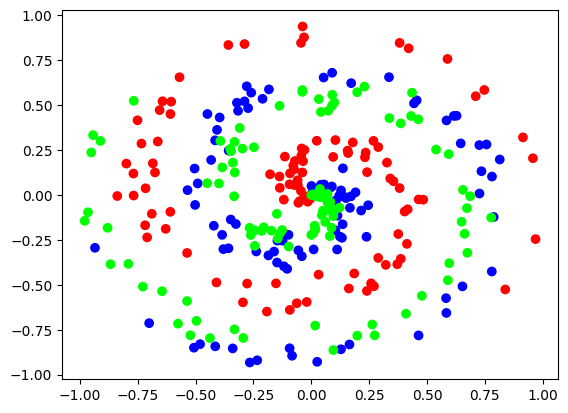

In [4]:
import matplotlib.pyplot as plt

X, y = spiral_data(samples=100, classes=config.num_classes)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')
plt.show()

<div class="alert alert-block alert-danger">



CREATING LAYERS: FORWARD AND BACKWARD PASS</div>

In [5]:
class Layer_Dense:

    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0, bias_regularizer_l1=0, bias_regularizer_l2=0):

        # Initialize weights and biases
        self.weights = config.weight_initiase_factor* np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):

        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1

        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights

        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1

        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

        self.dinputs = np.dot(dvalues, self.weights.T)

<div class="alert alert-block alert-danger">



RELU ACTIVATION: FORWARD AND BACKWARD PASS</div>

In [6]:
class Activation_ReLU:

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

<div class="alert alert-block alert-danger">



SOFTMAX ACTIVATION: FORWARD PASS</div>

In [7]:
class Activation_Softmax:
    
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
        self.output = probabilities

<div class="alert alert-block alert-danger">

LOSS CLASS </div>

In [8]:
# Common loss class

class Loss:

    # Regularization loss calculation
    def regularization_loss(self, layer):

        regularization_loss = 0

        # L1 regularization - weights
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:

            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)

        # L1 regularization - biases
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)

        return regularization_loss



    # Calculates the data and regularization losses given model output and ground truth values
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

<div class="alert alert-block alert-danger">



CATEGORICAL CROSS ENTROPY LOSS: FORWARD AND BACKWARD PASS</div>

In [9]:
class Loss_CategoricalCrossentropy(Loss):

    def forward(self, y_pred, y_true):
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value

        y_pred_clipped = np.clip(y_pred, config.output_clip , 1 - config.output_clip)

        # Probabilities for target values - only if categorical labels        
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[ range(samples),y_true]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum( y_pred_clipped * y_true,axis=1)

        
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods


    # Backward pass
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])


        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues

        # Normalize gradient
        self.dinputs = self.dinputs / samples

<div class="alert alert-block alert-danger">



COMBINED SOFTMAX ACTIVATION AND CATEGORICAL CROSS ENTROPY FOR LAST LAYER: FORWARD AND BACKWARD PASS</div>

In [10]:
# Softmax classifier - combined Softmax activation and cross-entropy loss for faster backward step


class Activation_Softmax_Loss_CategoricalCrossentropy:

    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    def forward(self, inputs, y_true):

        # Output layer's activation function
        self.activation.forward(inputs)

        # Set the output
        self.output = self.activation.output

        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    
    def backward(self, dvalues, y_true):
        
        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded, turn them into discrete values

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1

        # Normalize gradient
        self.dinputs = self.dinputs / samples

<div class="alert alert-block alert-danger">



SGD OPTIMIZER WITH LEARNING RATE DECAY and MOMENTUM </div>

In [11]:
import numpy as np

class Optimizer_SGD_with_Momentum:
    
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):

        if self.momentum:
            # If layer does not contain momentum arrays, create them filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        # Update weights and biases using either vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1


<div class="alert alert-block alert-danger">



Adagrad OPTIMIZER</div>

In [12]:
class Optimizer_Adagrad:

    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        
        # If layer does not contain cache arrays, create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Vanilla SGD parameter update + normalization with square rooted cache
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1


<div class="alert alert-block alert-danger">



RMSProp OPTIMIZER</div>

In [13]:
import numpy as np

class Optimizer_RMSprop:
    
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2

        # Vanilla SGD parameter update + normalization with square rooted cache
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


<div class="alert alert-block alert-danger">



ADAM OPTIMIZER</div>

In [14]:
class Optimizer_Adam:

    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):

        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2


    def pre_update_params(self):

        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))


    def update_params(self, layer):

        # If layer does not contain cache arrays, create them filled with zeros
        if not hasattr(layer, 'weight_cache'):

            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)



        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases



        # Get corrected momentum
        # self.iteration is 0 at first pass and we need to start with 1 here

        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))


        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        
        # Vanilla SGD parameter update + normalization with square rooted cache
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)


    
    def post_update_params(self):
        self.iterations += 1

<div class="alert alert-block alert-danger">



DROPOUT LAYER: FORWARD AND BACKWARD PASS</div>

In [15]:
class Layer_Dropout:

    def __init__(self, rate):

        # Store the dropout rate, invert it to get the success rate
        # For example, for a dropout of 0.1, we need a success rate of 0.9
        self.rate = 1 - rate

    def forward(self, inputs):

        self.inputs = inputs

        # Generate and save the scaled binary mask
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate

        # Apply mask to output values
        self.output = inputs * self.binary_mask

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask

<div class="alert alert-block alert-danger">



TRAINING THE NEURAL NETWORK</div>

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Create dataset
X, y = spiral_data(samples=config.train_samples, classes=config.num_classes)
X_val, y_val = spiral_data(samples=config.validation_samples, classes=config.num_classes)

# Create layers
dense1 = Layer_Dense(config.input_dim, config.hidden_1_dim, weight_regularizer_l2=config.weight_regularizer_l2, bias_regularizer_l2=config.bias_regularizer_l2)
activation1 = Activation_ReLU()

dropout1 = Layer_Dropout(config.dropout_rate)

dense2 = Layer_Dense(config.hidden_1_dim, config.num_classes)
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_Adam(learning_rate=config.learning_rate, decay=config.decay)

# Initialize lists to store training history
loss_history = []
train_acc_history = []
val_acc_history = []
lr_history = []

# Train in loop
for epoch in range(config.epochs):
    # Perform a forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dropout1.forward(activation1.output)
    dense2.forward(dropout1.output)
    data_loss = loss_activation.forward(dense2.output, y)

    # Calculate regularization penalty
    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)
    loss = data_loss + regularization_loss

    # Calculate accuracy
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    train_accuracy = np.mean(predictions == y)

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

    # Log training progress
    loss_history.append(loss)
    train_acc_history.append(train_accuracy)
    lr_history.append(optimizer.current_learning_rate)

    if not epoch % config.log_step:
        # Evaluate on validation set
        dense1.forward(X_val)
        activation1.forward(dense1.output)
        dropout1.forward(activation1.output)
        dense2.forward(dropout1.output)
        val_loss = loss_activation.forward(dense2.output, y_val)
        val_predictions = np.argmax(loss_activation.output, axis=1)
        if len(y_val.shape) == 2:
            y_val = np.argmax(y_val, axis=1)
        val_accuracy = np.mean(val_predictions == y_val)
        val_acc_history.append(val_accuracy)

        print(f'epoch: {epoch}, ' +
              f'acc: {train_accuracy:.3f}, ' +
              f'val_acc: {val_accuracy:.3f}, ' +
              f'loss: {loss:.3f} (' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}), ' +
              f'lr: {optimizer.current_learning_rate}')

epoch: 0, acc: 0.356, val_acc: 0.353, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 0.05
epoch: 100, acc: 0.613, val_acc: 0.601, loss: 0.904 (data_loss: 0.874, reg_loss: 0.030), lr: 0.04975124378109454
epoch: 200, acc: 0.622, val_acc: 0.616, loss: 0.850 (data_loss: 0.816, reg_loss: 0.033), lr: 0.04950495049504951
epoch: 300, acc: 0.633, val_acc: 0.627, loss: 0.828 (data_loss: 0.797, reg_loss: 0.031), lr: 0.049261083743842374
epoch: 400, acc: 0.646, val_acc: 0.625, loss: 0.817 (data_loss: 0.789, reg_loss: 0.029), lr: 0.049019607843137254
epoch: 500, acc: 0.642, val_acc: 0.639, loss: 0.810 (data_loss: 0.784, reg_loss: 0.027), lr: 0.04878048780487806
epoch: 600, acc: 0.647, val_acc: 0.641, loss: 0.806 (data_loss: 0.781, reg_loss: 0.025), lr: 0.048543689320388356
epoch: 700, acc: 0.642, val_acc: 0.651, loss: 0.806 (data_loss: 0.783, reg_loss: 0.023), lr: 0.04830917874396136
epoch: 800, acc: 0.639, val_acc: 0.657, loss: 0.810 (data_loss: 0.787, reg_loss: 0.022), lr: 0.048076923076923

In [17]:
# Test the model

X_test, y_test = spiral_data(samples=config.test_samples, classes=config.num_classes)


dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss = loss_activation.forward(dense2.output, y_test)


predictions = np.argmax(loss_activation.output, axis=1)

if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)


accuracy = np.mean(predictions == y_test)
print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')

validation, acc: 0.711, loss: 0.665


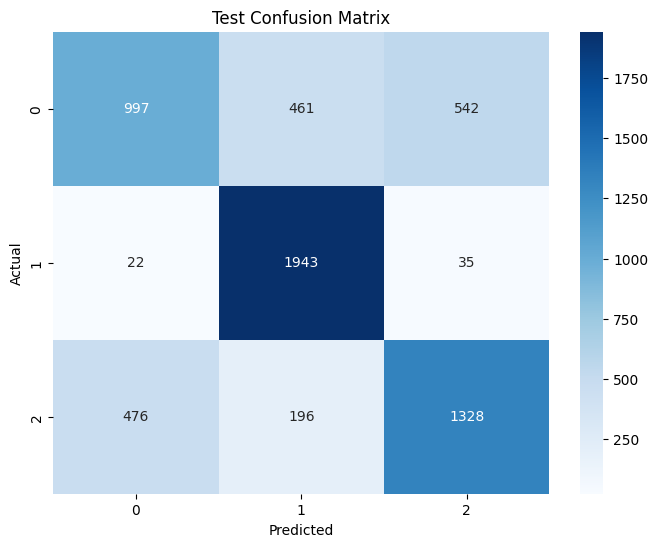

In [18]:
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sns

y_pred = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')
plt.show()

In [19]:
print('Test Classification Report:')
print(classification_report(y_test, y_pred))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.50      0.57      2000
           1       0.75      0.97      0.84      2000
           2       0.70      0.66      0.68      2000

    accuracy                           0.71      6000
   macro avg       0.70      0.71      0.70      6000
weighted avg       0.70      0.71      0.70      6000

